In [1]:
# !pip install matplotlib
import os
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql import functions as f
from pyspark.sql.types import StringType
import pandas as pd
import matplotlib.pyplot as plt

# set local variables


%env MINIO_PASSWORD 6HgSzdwj8eNpHcux
%env MINIO_USERNAME grupo-02

env: MINIO_PASSWORD=6HgSzdwj8eNpHcux
env: MINIO_USERNAME=grupo-02


In [2]:

os.environ[
    "PYSPARK_SUBMIT_ARGS"
] = "--packages org.apache.hadoop:hadoop-aws:3.2.2,io.delta:delta-core_2.12:1.1.0  pyspark-shell "
config = {
    "spark.jars.packages":"org.apache.hadoop:hadoop-aws:3.2.2",
    "spark.kubernetes.namespace": "spark",
    "spark.kubernetes.container.image": "cronosnull/abd-spark-base:202301",
    "spark.executor.instances": "20",
    "spark.executor.memory": "10g",
    "spark.executor.cores": "1",
    "spark.driver.memory":"5g",
    "spark.driver.port":"38891",
    "spark.driver.blockManager.port":"7779",
    "spark.driver.bindAddress": "0.0.0.0",
    "spark.driver.host":"172.24.99.147",
    "spark.kubernetes.executor.request.cores":"500m",
    "spark.hadoop.fs.s3a.endpoint": "http://172.24.99.18:9000",
    # Credenciales de MinNIO, no olvide asignar las variables de entorno
    "spark.hadoop.fs.s3a.access.key": os.environ.get('MINIO_USERNAME', "--"),
    "spark.hadoop.fs.s3a.secret.key": os.environ.get('MINIO_PASSWORD',"--"),
    "spark.hadoop.fs.s3a.path.style.access": True,
    "spark.hadoop.fs.s3a.impl": "org.apache.hadoop.fs.s3a.S3AFileSystem",
    "spark.hadoop.fs.s3a.aws.credentials.provider": "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider",
    "spark.kubernetes.local.dirs.tmpfs":True,

}
def get_spark_session(app_name: str, conf: SparkConf):
    conf.setMaster("k8s://https://172.24.99.68:16443")
    for key, value in config.items():
        conf.set(key, value)
    conf.set("spark.ui.port", "4041");
    return SparkSession.builder.appName(app_name).config(conf=conf).getOrCreate()

In [3]:
spark = get_spark_session("grupo-02-app-prueba", SparkConf())

In [4]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.2.0
      /_/
                        
Using Scala version 2.12.15, OpenJDK 64-Bit Server VM, 1.8.0_322
Branch 
Compiled by user  on 2022-03-26T09:34:47Z
Revision 
Url 
Type --help for more information.


In [5]:
spark

In [6]:
# spark.stop

# Parte 2


In [7]:
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import col, when
from pyspark.sql.functions import to_date
from pyspark.sql.functions import date_format


# Quitar espacios en los nombres es las columnas
def remove_space_in_names(df):
    for col_name in df.columns:
        new_col_name = col_name.replace(' ', '')
        df = df.withColumnRenamed(col_name, new_col_name)
    return df


# Cambiar los tipos de datos del dataframe
# Falta Rate_Code, store_and_forward, mta_tax
def change_name_and_data_type_G1(df):
    
    df = remove_space_in_names(df)

    df = df.withColumnRenamed("Trip_Pickup_DateTime", "pickup_datetime").withColumn("pickup_datetime", to_timestamp("pickup_datetime", "yyyy-MM-dd HH:mm:ss"))
    df = df.withColumnRenamed("Trip_Dropoff_DateTime", "dropoff_datetime").withColumn("dropoff_datetime", to_timestamp("dropoff_datetime", "yyyy-MM-dd HH:mm:ss")) 
    df = df.withColumnRenamed("Trip_Distance", "trip_distance").withColumn("trip_distance", col("trip_distance").cast("double"))
    df = df.withColumnRenamed("Start_Lon", "pickup_longitude").withColumn("pickup_longitude", col("pickup_longitude").cast("double"))
    df = df.withColumnRenamed("Start_Lat", "pickup_latitude").withColumn("pickup_latitude", col("pickup_latitude").cast("double"))
    df = df.withColumnRenamed("End_Lon", "dropoff_longitude").withColumn("dropoff_longitude", col("dropoff_longitude").cast("double"))
    df = df.withColumnRenamed("End_Lat", "dropoff_latitude").withColumn("dropoff_latitude", col("dropoff_latitude").cast("double"))
    df = df.withColumnRenamed("Total_Amt", "total_amount").withColumn("total_amount", col("total_amount").cast("double"))
    
    #Crear nueva columna
    df= df.withColumn("date_travel", date_format("pickup_datetime", "yyyy-MM-dd").alias("date_travel"))
    df = df.withColumn("date_travel", to_date("date_travel", "yyyy-MM-dd"))
    
    return df

def change_name_and_data_type_G2(df):
    
    df = remove_space_in_names(df)

    df = df.withColumnRenamed("pickup_datetime", "pickup_datetime").withColumn("pickup_datetime", to_timestamp("pickup_datetime", "yyyy-MM-dd HH:mm:ss"))
    df = df.withColumnRenamed("dropoff_datetime", "dropoff_datetime").withColumn("dropoff_datetime", to_timestamp("dropoff_datetime", "yyyy-MM-dd HH:mm:ss"))
    df = df.withColumnRenamed("trip_distance", "trip_distance").withColumn("trip_distance", col("trip_distance").cast("double"))
    df = df.withColumnRenamed("pickup_longitude", "pickup_longitude").withColumn("pickup_longitude", col("pickup_longitude").cast("double"))
    df = df.withColumnRenamed("pickup_latitude", "pickup_latitude").withColumn("pickup_latitude", col("pickup_latitude").cast("double"))
    df = df.withColumnRenamed("dropoff_longitude", "dropoff_longitude").withColumn("dropoff_longitude", col("dropoff_longitude").cast("double"))
    df = df.withColumnRenamed("dropoff_latitude", "dropoff_latitude").withColumn("dropoff_latitude", col("dropoff_latitude").cast("double"))
    df = df.withColumnRenamed("total_amount", "total_amount").withColumn("total_amount", col("total_amount").cast("double"))
    
   
    #Crear nueva columna
    df= df.withColumn("date_travel", date_format("pickup_datetime", "yyyy-MM-dd").alias("date_travel"))
    df = df.withColumn("date_travel", to_date("date_travel", "yyyy-MM-dd"))
    
    return df


def change_name_and_data_type_G3(df):
    
    df = remove_space_in_names(df)

    
    df = df.withColumnRenamed("tpep_pickup_datetime", "pickup_datetime").withColumn("pickup_datetime", to_timestamp("pickup_datetime", "yyyy-MM-dd HH:mm:ss"))
    df = df.withColumnRenamed("tpep_dropoff_datetime", "dropoff_datetime").withColumn("dropoff_datetime", to_timestamp("dropoff_datetime", "yyyy-MM-dd HH:mm:ss"))
    df = df.withColumnRenamed("trip_distance", "trip_distance").withColumn("trip_distance", col("trip_distance").cast("double"))
    df = df.withColumnRenamed("pickup_longitude", "pickup_longitude").withColumn("pickup_longitude", col("pickup_longitude").cast("double"))
    df = df.withColumnRenamed("pickup_latitude", "pickup_latitude").withColumn("pickup_latitude", col("pickup_latitude").cast("double"))
    df = df.withColumnRenamed("dropoff_longitude", "dropoff_longitude").withColumn("dropoff_longitude", col("dropoff_longitude").cast("double"))
    df = df.withColumnRenamed("dropoff_latitude", "dropoff_latitude").withColumn("dropoff_latitude", col("dropoff_latitude").cast("double"))
    df = df.withColumnRenamed("total_amount", "total_amount").withColumn("total_amount", col("total_amount").cast("double"))
   
    #Eliminar columna no usada
    df = df.drop("extra")
    
   
    #Crear nueva columna
    df= df.withColumn("date_travel", date_format("pickup_datetime", "yyyy-MM-dd").alias("date_travel"))
    df = df.withColumn("date_travel", to_date("date_travel", "yyyy-MM-dd"))
    
    return df


def change_name_and_data_type_G4(df):
    
    df = remove_space_in_names(df)

    df = df.withColumnRenamed("tpep_pickup_datetime", "pickup_datetime").withColumn("pickup_datetime", to_timestamp("pickup_datetime", "yyyy-MM-dd HH:mm:ss"))
    df = df.withColumnRenamed("tpep_dropoff_datetime", "dropoff_datetime").withColumn("dropoff_datetime", to_timestamp("dropoff_datetime", "yyyy-MM-dd HH:mm:ss"))
    df = df.withColumnRenamed("trip_distance", "trip_distance").withColumn("trip_distance", col("trip_distance").cast("double"))
    df = df.withColumn("PULocationID", col("PULocationID").cast("integer"))
    df = df.withColumn("DOLocationID", col("DOLocationID").cast("integer"))
    df = df.withColumnRenamed("total_amount", "total_amount").withColumn("total_amount", col("total_amount").cast("double"))
    
    #Eliminar columna no usada
    df = df.drop("extra")
    
    #Crear nueva columna
    df= df.withColumn("date_travel", date_format("pickup_datetime", "yyyy-MM-dd").alias("date_travel"))
    df = df.withColumn("date_travel", to_date("date_travel", "yyyy-MM-dd"))
    
    return df

In [8]:
# charge info group 1
df_taxis_G1 = spark.read.csv("s3a://taxis/yellow_tripdata_2009-*.csv.gz", header=True)
df_taxis_G1 = df_taxis_G1.select(df_taxis_G1.Trip_Pickup_DateTime, df_taxis_G1.Trip_Dropoff_DateTime, df_taxis_G1.Trip_Distance, df_taxis_G1.Start_Lon, df_taxis_G1.Start_Lat, df_taxis_G1.End_Lon, df_taxis_G1.End_Lat, df_taxis_G1.Total_Amt)
df_taxis_G1_change_type = change_name_and_data_type_G1(df_taxis_G1)

df_taxis_G1_change_type.printSchema()

root
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- date_travel: date (nullable = true)



In [ ]:
# charge info group 2

df_taxis_G2_2010 = spark.read.csv("s3a://taxis/yellow_tripdata_2010-*.csv.gz", header=True)
df_taxis_G2_2010 = df_taxis_G2_2010.select(df_taxis_G2_2010.pickup_datetime , df_taxis_G2_2010.dropoff_datetime, df_taxis_G2_2010.trip_distance, df_taxis_G2_2010.pickup_longitude, df_taxis_G2_2010.pickup_latitude, df_taxis_G2_2010.dropoff_longitude, df_taxis_G2_2010.dropoff_latitude, df_taxis_G2_2010.total_amount)
df_taxis_G2_2010_change_type = change_name_and_data_type_G2(df_taxis_G2_2010)


df_taxis_G2_2011 = spark.read.csv("s3a://taxis/yellow_tripdata_2011-*.csv.gz", header=True)
df_taxis_G2_2011 = df_taxis_G2_2011.select(df_taxis_G2_2011.pickup_datetime , df_taxis_G2_2011.dropoff_datetime, df_taxis_G2_2011.trip_distance, df_taxis_G2_2011.pickup_longitude, df_taxis_G2_2011.pickup_latitude, df_taxis_G2_2011.dropoff_longitude, df_taxis_G2_2011.dropoff_latitude, df_taxis_G2_2011.total_amount)
df_taxis_G2_2011_change_type = change_name_and_data_type_G2(df_taxis_G2_2011)

df_taxis_G2_2012 = spark.read.csv("s3a://taxis/yellow_tripdata_2012-*.csv.gz", header=True)
df_taxis_G2_2012 = df_taxis_G2_2012.select(df_taxis_G2_2012.pickup_datetime , df_taxis_G2_2012.dropoff_datetime, df_taxis_G2_2012.trip_distance, df_taxis_G2_2012.pickup_longitude, df_taxis_G2_2012.pickup_latitude, df_taxis_G2_2012.dropoff_longitude, df_taxis_G2_2012.dropoff_latitude, df_taxis_G2_2012.total_amount)
df_taxis_G2_2012_change_type = change_name_and_data_type_G2(df_taxis_G2_2012)

df_taxis_G2_2013 = spark.read.csv("s3a://taxis/yellow_tripdata_2013-*.csv.gz", header=True)
df_taxis_G2_2013 = df_taxis_G2_2013.select(df_taxis_G2_2013.pickup_datetime , df_taxis_G2_2013.dropoff_datetime, df_taxis_G2_2013.trip_distance, df_taxis_G2_2013.pickup_longitude, df_taxis_G2_2013.pickup_latitude, df_taxis_G2_2013.dropoff_longitude, df_taxis_G2_2013.dropoff_latitude, df_taxis_G2_2013.total_amount)
df_taxis_G2_2013_change_type = change_name_and_data_type_G2(df_taxis_G2_2013)

df_taxis_G2_2014 = spark.read.csv("s3a://taxis/yellow_tripdata_2014-*.csv.gz", header=True)
df_taxis_G2_2014_change_type = change_name_and_data_type_G2(df_taxis_G2_2014)
df_taxis_G2_2014 = df_taxis_G2_2014.select(df_taxis_G2_2014.pickup_datetime , df_taxis_G2_2014.dropoff_datetime, df_taxis_G2_2014.trip_distance, df_taxis_G2_2014.pickup_longitude, df_taxis_G2_2014.pickup_latitude, df_taxis_G2_2014.dropoff_longitude, df_taxis_G2_2014.dropoff_latitude, df_taxis_G2_2014.total_amount)


df_taxis_G2_change_type = df_taxis_G2_2010_change_type.unionAll(df_taxis_G2_2011_change_type).unionAll(df_taxis_G2_2013_change_type).unionAll(df_taxis_G2_2014_change_type)

df_taxis_G1_change_type.printSchema()


In [ ]:
# charge info group 3

df_taxis_G3_2015 = spark.read.csv("s3a://taxis/yellow_tripdata_2015-*.csv.gz", header=True)
df_taxis_G3_2015 = df_taxis_G3_2015.select(df_taxis_G3_2015.tpep_pickup_datetime, df_taxis_G3_2015.tpep_dropoff_datetime, df_taxis_G3_2015.trip_distance, df_taxis_G3_2015.pickup_longitude, df_taxis_G3_2015.pickup_latitude, df_taxis_G3_2015.dropoff_longitude, df_taxis_G3_2015.dropoff_latitude, df_taxis_G3_2015.total_amount)
df_taxis_G3_2015_change_type = change_name_and_data_type_G3(df_taxis_G3_2015)

df_taxis_G3_2016 = spark.read.csv("s3a://taxis/yellow_tripdata_2016-*.csv.gz", header=True)
df_taxis_G3_2016 = df_taxis_G3_2016.select(df_taxis_G3_2016.tpep_pickup_datetime, df_taxis_G3_2016.tpep_dropoff_datetime, df_taxis_G3_2016.trip_distance, df_taxis_G3_2016.pickup_longitude, df_taxis_G3_2016.pickup_latitude, df_taxis_G3_2016.dropoff_longitude, df_taxis_G3_2016.dropoff_latitude, df_taxis_G3_2016.total_amount)
df_taxis_G3_2016_change_type = change_name_and_data_type_G3(df_taxis_G3_2016)

df_taxis_G3_change_type = df_taxis_G3_2015_change_type.unionAll(df_taxis_G3_2016_change_type)

df_taxis_G3_change_type.printSchema()

In [ ]:
# charge info group 4

df_taxis_G4_2017 = spark.read.csv("s3a://taxis/yellow_tripdata_2017-*.csv.gz", header=True)
df_taxis_G4_2017 = df_taxis_G4_2017.select(df_taxis_G4_2017.tpep_pickup_datetime, df_taxis_G4_2017.tpep_dropoff_datetime, df_taxis_G4_2017.trip_distance, df_taxis_G4_2017.PULocationID, df_taxis_G4_2017.DOLocationID,  df_taxis_G4_2017.total_amount)
df_taxis_G4_2017_change_type = change_name_and_data_type_G4(df_taxis_G4_2017)

df_taxis_G4_2018 = spark.read.csv("s3a://taxis/yellow_tripdata_2018-*.csv.gz", header=True)
df_taxis_G4_2018 = df_taxis_G4_2018.select(df_taxis_G4_2018.tpep_pickup_datetime, df_taxis_G4_2018.tpep_dropoff_datetime, df_taxis_G4_2018.trip_distance, df_taxis_G4_2018.PULocationID, df_taxis_G4_2018.DOLocationID,  df_taxis_G4_2018.total_amount)
df_taxis_G4_2018_change_type = change_name_and_data_type_G4(df_taxis_G4_2018)

df_taxis_G4_2019 = spark.read.csv("s3a://taxis/yellow_tripdata_2019-*.csv.gz", header=True)
df_taxis_G4_2019 = df_taxis_G4_2019.select(df_taxis_G4_2019.tpep_pickup_datetime, df_taxis_G4_2019.tpep_dropoff_datetime, df_taxis_G4_2019.trip_distance, df_taxis_G4_2019.PULocationID, df_taxis_G4_2019.DOLocationID,  df_taxis_G4_2019.total_amount)
df_taxis_G4_2019 = df_taxis_G4_2019.drop("congestion_surcharge")
df_taxis_G4_2019_change_type = change_name_and_data_type_G4(df_taxis_G4_2019)


df_taxis_G4_change_type = df_taxis_G4_2017_change_type.unionAll(df_taxis_G4_2018_change_type).unionAll(df_taxis_G4_2019_change_type)

df_taxis_G4_change_type.printSchema()



In [ ]:
# Add the zone name
df_taxis_G4_change_type_2 = df_taxis_G4_change_type

df_location_id = spark.read.csv("s3a://user-data/grupo-02/taxi+_zone_lookup.csv", header=True)

df_location_id.head(4)

In [ ]:
# Add the zone to the dataframe 4 
df_taxis_G4_change_type_2 = df_taxis_G4_change_type

df_taxis_G4_change_type_2 = df_taxis_G4_change_type_2.join(df_location_id, df_taxis_G4_change_type_2.PULocationID == df_location_id.LocationID).select(df_taxis_G4_change_type_2['*'], df_location_id['Zone'])
df_taxis_G4_change_type_2 = df_taxis_G4_change_type_2.withColumnRenamed("Zone", "pickup_zone")

df_taxis_G4_change_type_2 = df_taxis_G4_change_type_2.alias('a').join(df_location_id.alias('b'), df_taxis_G4_change_type_2.alias('a').DOLocationID == df_location_id.alias('b').LocationID).select('a.*','b.Zone')
df_taxis_G4_change_type_2 = df_taxis_G4_change_type_2.withColumnRenamed("Zone", "dropoff_zone")
    
df_taxis_G4_change_type_2 = df_taxis_G4_change_type_2.drop('DOLocationID','PULocationID')
df_taxis_G4_change_type_2.printSchema()



In [9]:
# Join all the data with latitude and longitud

df_taxis_with_lat_lon = df_taxis_G1_change_type.unionAll(df_taxis_G2_change_type).unionAll(df_taxis_G3_change_type)

df_taxis_with_lat_lon.printSchema()

root
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- date_travel: date (nullable = true)



## Geo pandas


In [ ]:
# !pip install geopandas

In [10]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, shape
from shapely import wkb, wkt
from pyspark.sql.functions import *
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType,DecimalType
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import udf

import shapely.speedups
shapely.speedups.enable() # this makes some spatial queries run faster

#Load the data 
df_taxi_zones_csv = spark.read.csv("s3a://user-data/grupo-02/taxi_zones.csv", header=True)
df_taxi_zones_csv.printSchema()

# define a function to convert a WKT string to a Shapely geometry object
def wkt_to_geometry(wkt_str):
    return wkt.loads(wkt_str)

# read in the CSV file and convert the 'the_geom' column to a geometry data type
df_taxi_zones_csv = pd.read_csv("taxi_zones.csv", dtype={'the_geom': 'str'}).assign(the_geom=lambda x: x['the_geom'].apply(wkt_to_geometry))

# print the data types of the columns
print(df_taxi_zones_csv.dtypes)

gdf  = gpd.GeoDataFrame(df_taxi_zones_csv, geometry='the_geom')

# spark.broadcast(gdf)

def find_zone(latitude, longitude): 
    mgdf = gdf.apply(lambda x: x['zone'] if x['the_geom'].intersects(Point(longitude,latitude)) else None, axis=1)
    idx = mgdf.first_valid_index()
    first_valid_value = mgdf.loc[idx] if idx is not None else None
    return first_valid_value



find_zone_udf = udf(lambda lat, lon: find_zone(lat, lon), StringType())




root
 |-- OBJECTID: string (nullable = true)
 |-- Shape_Leng: string (nullable = true)
 |-- the_geom: string (nullable = true)
 |-- Shape_Area: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- LocationID: string (nullable = true)
 |-- borough: string (nullable = true)

OBJECTID        int64
Shape_Leng    float64
the_geom       object
Shape_Area    float64
zone           object
LocationID      int64
borough        object
dtype: object


In [11]:

df_taxis_with_lat_lon= df_taxis_with_lat_lon.withColumn("pickup_zone", find_zone_udf(col("pickup_latitude"),col("pickup_longitude")))

df_taxis_with_lat_lon= df_taxis_with_lat_lon.withColumn("dropoff_zone", find_zone_udf(col("dropoff_latitude"),col("dropoff_longitude")))

df_taxis_with_lat_lon = df_taxis_with_lat_lon.drop('pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')
df_taxis_with_lat_lon.printSchema()


root
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- date_travel: date (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [12]:
# Join all the data

final_df_taxi_zones  = df_taxis_with_lat_lon.unionAll(df_taxis_G4_change_type_2)

final_df_taxi_zones= final_df_taxi_zones.withColumn("year_travel", date_format("pickup_datetime", "yyyy").alias("year_travel"))
final_df_taxi_zones= final_df_taxi_zones.withColumn("month_travel", date_format("pickup_datetime", "MM").alias("month_travel"))
final_df_taxi_zones= final_df_taxi_zones.withColumn("day_travel", date_format("pickup_datetime", "dd").alias("day_travel"))


final_df_taxi_zones = final_df_taxi_zones.withColumn("year_travel", col("year_travel").cast("integer"))
final_df_taxi_zones = final_df_taxi_zones.withColumn("month_travel", col("year_travel").cast("integer"))
final_df_taxi_zones = final_df_taxi_zones.withColumn("day_travel", col("year_travel").cast("integer"))


final_df_taxi_zones.printSchema()


root
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- date_travel: date (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)
 |-- year_travel: integer (nullable = true)
 |-- month_travel: integer (nullable = true)
 |-- day_travel: integer (nullable = true)



In [ ]:
# Se crea un dataframe para analizar los datos

pd_df_final_df_taxi_zones = final_df_taxi_zones.toPandas()


In [ ]:
# Se sube el CSV a Minio

final_df_taxi_zones.write.mode("overwrite").csv("s3a://user-data/grupo-02/prueba/final_df_taxi_zones.csv")

# Analisis de los datos


## Punto G


In [35]:
from pyspark.sql.functions import year
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import FixedLocator

In [36]:
# columnas 
data = final_df_taxi_zones.select("pickup_zone", "dropoff_zone", "year_travel")


In [38]:
# Agrupar por año, zona de origen y zona de entrega y hacer el conteo
grouped_data = data.groupBy("year_travel", "pickup_zone", "dropoff_zone").count()


In [39]:
# Ordenar por año y conteo de manera descendente
sorted_data = grouped_data.orderBy("year_travel", "count", ascending=[True, False])


In [40]:

# pivote con zonas de 
pivoted_data = pd.pivot_table(sorted_data.toPandas(), values="count", index=["pickup_zone"], columns=["dropoff_zone"])


<ipython-input-41-0135cb2f5da8>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pivoted_data.columns, minor=False, rotation=90, ha="center", fontsize=8)
<ipython-input-41-0135cb2f5da8>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(pivoted_data.index, minor=False, fontsize=8)


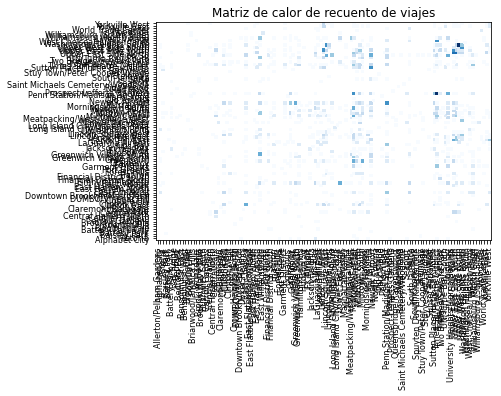

In [41]:

# Obtener una matriz NumPy de los valores de la tabla
matrix_data = pivoted_data.values

fig, ax = plt.subplots()

# matriz de calor
heatmap = ax.pcolor(matrix_data, cmap=plt.cm.Blues)

# etiquetas de eje
ax.set_xticklabels(pivoted_data.columns, minor=False, rotation=90, ha="center", fontsize=8)
ax.xaxis.set_major_locator(FixedLocator(np.arange(0.5, len(pivoted_data.columns), 1)))
ax.set_yticklabels(pivoted_data.index, minor=False, fontsize=8)
ax.yaxis.set_major_locator(FixedLocator(np.arange(0.5, len(pivoted_data.index), 1)))


# Rotar las etiquetas de eje x 
plt.xticks(rotation=90)

# título
plt.title('Matriz de calor de recuento de viajes')

plt.show()

## Punto H


In [24]:
from pyspark.sql.functions import count, desc


In [25]:
most_popular_destinations_per_years = final_df_taxi_zones.groupBy('year_travel', 'dropoff_zone').count()

In [26]:
most_popular_destinations_per_years_sorted = most_popular_destinations_per_years.orderBy(['year_travel', 'count'], ascending=[False, False])


In [27]:
most_popular_destinations_per_years_sorted.head(20)


[Row(year_travel=2009, dropoff_zone='Midtown Center', count=76),
 Row(year_travel=2009, dropoff_zone='Murray Hill', count=61),
 Row(year_travel=2009, dropoff_zone='Times Sq/Theatre District', count=60),
 Row(year_travel=2009, dropoff_zone='Upper East Side North', count=55),
 Row(year_travel=2009, dropoff_zone='Upper East Side South', count=53),
 Row(year_travel=2009, dropoff_zone='Penn Station/Madison Sq West', count=51),
 Row(year_travel=2009, dropoff_zone='Midtown North', count=49),
 Row(year_travel=2009, dropoff_zone='Lenox Hill West', count=48),
 Row(year_travel=2009, dropoff_zone='Union Sq', count=48),
 Row(year_travel=2009, dropoff_zone='East Village', count=45),
 Row(year_travel=2009, dropoff_zone=None, count=44),
 Row(year_travel=2009, dropoff_zone='Midtown East', count=40),
 Row(year_travel=2009, dropoff_zone='Upper West Side South', count=40),
 Row(year_travel=2009, dropoff_zone='Sutton Place/Turtle Bay North', count=39),
 Row(year_travel=2009, dropoff_zone='Lincoln Square Ea

## Punto I

In [28]:
from pyspark.sql.functions import sum
from pyspark.sql.functions import lit

In [29]:
df_km_per_year = final_df_taxi_zones.groupby('year_travel').agg(sum('trip_distance').alias('trip_distance'))


In [30]:
# convert miles to kilometers
df_km_per_year = df_km_per_year.withColumn('trip_distance_km', df_km_per_year['trip_distance'] * lit(1.609344))


+-----------+-------------+----------------+
|year_travel|trip_distance|trip_distance_km|
+-----------+-------------+----------------+
|       2009|     4669.226|  7514.390847744|
+-----------+-------------+----------------+



In [31]:
# convert spark df into pandas dataframe
pd_df_df_km_per_year = df_km_per_year.toPandas()

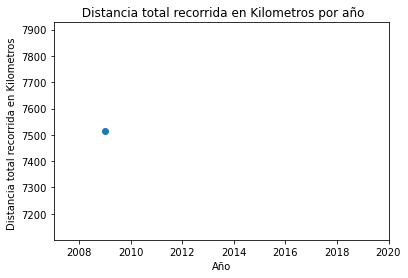

In [34]:
plt.plot(pd_df_df_km_per_year["year_travel"], pd_df_df_km_per_year["trip_distance_km"], '-o')


plt.xlabel('Año')
plt.xlim(2007, 2020)

plt.ylabel('Distancia total recorrida en Kilometros ')

plt.title(' Distancia total recorrida en Kilometros por año')

plt.show()

## Punto J

In [13]:
most_popular_destination_per_year_per_month = final_df_taxi_zones.groupby(["year_travel", "month_travel", 'dropoff_zone']).count()

In [14]:
from pyspark.sql.functions import count, desc, mean

In [15]:
most_popular_destination_per_year_per_month = most_popular_destination_per_year_per_month.orderBy(['year_travel', 'month_travel', 'count'], ascending=[False, False, False])

In [16]:
most_popular_destination_per_year_per_month.head(10)

[Row(year_travel=2009, month_travel=2009, dropoff_zone='Midtown Center', count=76),
 Row(year_travel=2009, month_travel=2009, dropoff_zone='Murray Hill', count=61),
 Row(year_travel=2009, month_travel=2009, dropoff_zone='Times Sq/Theatre District', count=60),
 Row(year_travel=2009, month_travel=2009, dropoff_zone='Upper East Side North', count=55),
 Row(year_travel=2009, month_travel=2009, dropoff_zone='Upper East Side South', count=53),
 Row(year_travel=2009, month_travel=2009, dropoff_zone='Penn Station/Madison Sq West', count=51),
 Row(year_travel=2009, month_travel=2009, dropoff_zone='Midtown North', count=49),
 Row(year_travel=2009, month_travel=2009, dropoff_zone='Lenox Hill West', count=48),
 Row(year_travel=2009, month_travel=2009, dropoff_zone='Union Sq', count=48),
 Row(year_travel=2009, month_travel=2009, dropoff_zone='East Village', count=45)]

## Punto K

¿Cuál es la tarifa promedio por destino por año?

In [19]:
most_expensive_destination_per_year = final_df_taxi_zones.groupby(["year_travel", 'dropoff_zone']).agg(mean("total_amount"))


In [20]:
most_expensive_destination_per_year = final_df_taxi_zones.groupby(["year_travel", 'dropoff_zone']).agg(mean("total_amount"))


In [21]:
most_expensive_destination_per_year.head(10)

[Row(year_travel=2009, dropoff_zone='Newark Airport', avg(total_amount)=70.14999999999999),
 Row(year_travel=2009, dropoff_zone='Sunset Park West', avg(total_amount)=52.7),
 Row(year_travel=2009, dropoff_zone='Madison', avg(total_amount)=51.17),
 Row(year_travel=2009, dropoff_zone='JFK Airport', avg(total_amount)=48.22923076923077),
 Row(year_travel=2009, dropoff_zone='Allerton/Pelham Gardens', avg(total_amount)=47.8),
 Row(year_travel=2009, dropoff_zone='University Heights/Morris Heights', avg(total_amount)=47.3),
 Row(year_travel=2009, dropoff_zone='Fort Greene', avg(total_amount)=45.0),
 Row(year_travel=2009, dropoff_zone='Bensonhurst West', avg(total_amount)=44.2),
 Row(year_travel=2009, dropoff_zone='Bay Ridge', avg(total_amount)=39.8),
 Row(year_travel=2009, dropoff_zone='Spuyten Duyvil/Kingsbridge', avg(total_amount)=39.735)]